In [18]:
# Imports & Settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns  

import datetime as dt

# Fix for pyfolio compatibility with newer seaborn versions
import pyfolio.plotting
original_plot_perf_stats = pyfolio.plotting.plot_perf_stats

def patched_plot_perf_stats(returns, factor_returns=None, ax=None, **kwargs):
    """
    Patched version of plot_perf_stats to handle seaborn compatibility issues
    """
    try:
        return original_plot_perf_stats(returns, factor_returns, ax, **kwargs)
    except (UnboundLocalError, AttributeError, TypeError) as e:
        print(f"Performance stats plot skipped due to compatibility issue: {e}")
        if ax is None:
            fig, ax = plt.subplots(figsize=(14, 5))
        ax.text(0.5, 0.5, 'Performance stats plot unavailable\n(compatibility issue with seaborn)', 
                ha='center', va='center', transform=ax.transAxes, fontsize=12)
        ax.set_title('Performance Statistics (Plot Unavailable)')
        return ax

# Apply the patch
pyfolio.plotting.plot_perf_stats = patched_plot_perf_stats

from pyfolio.plotting import (plot_perf_stats,
                            # show_perf_stats,
                              plot_rolling_beta,
                            # plot_rolling_returns,
                              plot_rolling_sharpe,
                              plot_drawdown_periods,
                              plot_drawdown_underwater)

from pyfolio.timeseries import perf_stats #, extract_interesting_date_ranges

# Load environment variables
from dotenv import load_dotenv
import os
from pathlib import Path

# Load .env file from current directory
env_path = Path('.env')
load_dotenv(env_path);

In [19]:
# # Compatibility patches for pyfolio with newer seaborn versions
# import pyfolio.plotting

# # Store original functions
# original_plot_perf_stats = pyfolio.plotting.plot_perf_stats

# def patched_plot_perf_stats(returns, factor_returns=None, ax=None, **kwargs):
#     """
#     Patched version of plot_perf_stats to handle seaborn compatibility issues
#     """
#     try:
#         return original_plot_perf_stats(returns, factor_returns, ax, **kwargs)
#     except (UnboundLocalError, AttributeError, TypeError) as e:
#         print(f"Performance stats plot skipped due to compatibility issue: {e}")
#         if ax is None:
#             fig, ax = plt.subplots(figsize=(14, 5))
        
#         # Create a simple alternative visualization
#         ax.text(0.5, 0.5, 'Performance Stats Plot Unavailable\n(Seaborn compatibility issue)', 
#                 ha='center', va='center', transform=ax.transAxes, fontsize=12, 
#                 bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
#         ax.set_title('Performance Statistics')
#         ax.axis('off')
#         return ax

# # Apply the patch
# pyfolio.plotting.plot_perf_stats = patched_plot_perf_stats

# print("Pyfolio compatibility patches applied successfully!")

In [20]:
# Get paths from environment variables
path_daily_returns_spy = os.getenv('path_daily_returns_spy')
path_daily_returns_strategies = os.getenv('path_daily_returns_strategies')

daily_returns_spy = pd.read_csv(path_daily_returns_spy, index_col=0, parse_dates=True, sep=';')
daily_returns_strategies = pd.read_csv(path_daily_returns_strategies, index_col=0, parse_dates=True, sep=';')

In [21]:
# rename the columns
daily_returns_spy.columns = ['daily_returns_spy']
daily_returns_strategies.columns = ['daily_returns_strategies']

In [22]:
# SPY daily returns
benchmark_rets = daily_returns_spy.copy()

# rename the columns
benchmark_rets.columns = ['pct_change']

# fill the missing values with 0
benchmark_rets.fillna(0, inplace=True)

benchmark_rets.head()

,pct_change
datetime,
2023-04-19 16:30:00,0.000000
2023-04-20 16:30:00,-0.005457
2023-04-21 16:30:00,0.000777
2023-04-24 16:30:00,0.001043
2023-04-25 16:30:00,-0.015874


In [23]:
returns = daily_returns_strategies.copy()

# rename the columns
returns.columns = ['returns']

returns.head()

,returns
Date,
2023-04-17,0.053095
2023-04-18,-0.000460
2023-04-19,-0.005545
2023-04-20,-0.000670
2023-04-21,0.004506


In [24]:
perf_stats(returns=returns['returns'],
           factor_returns=benchmark_rets['pct_change'])
#            positions=positions, 
#            transactions=transactions)

Annual return           0.439823
Cumulative returns      1.531110
Annual volatility       0.261315
Sharpe ratio            1.524173
Calmar ratio            1.830675
Stability               0.844743
Max drawdown           -0.240252
Omega ratio             1.382741
Sortino ratio           2.808511
Skew                    1.573189
Kurtosis               10.243098
Tail ratio              1.587455
Daily value at risk    -0.031342
Alpha                        NaN
Beta                         NaN
dtype: float64

Performance stats plot skipped due to compatibility issue: cannot access local variable 'boxprops' where it is not associated with a value


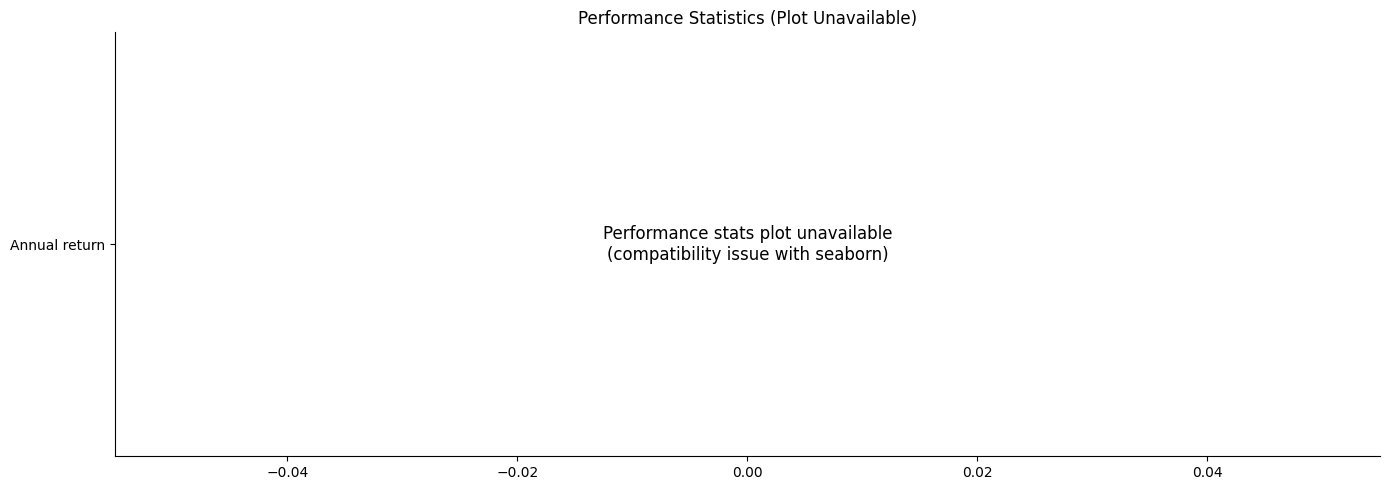

In [25]:
# Align the series
rets = returns['returns'].dropna()
bench = benchmark_rets['pct_change'].dropna()
common_idx = rets.index.intersection(bench.index)
rets = rets.loc[common_idx]
bench = bench.loc[common_idx]

fig, ax = plt.subplots(figsize=(14, 5))
plot_perf_stats(returns=rets, factor_returns=bench, ax=ax)
try:
    sns.despine()
except Exception as e:
    print("sns.despine() non ha avuto effetto:", e)
fig.tight_layout();

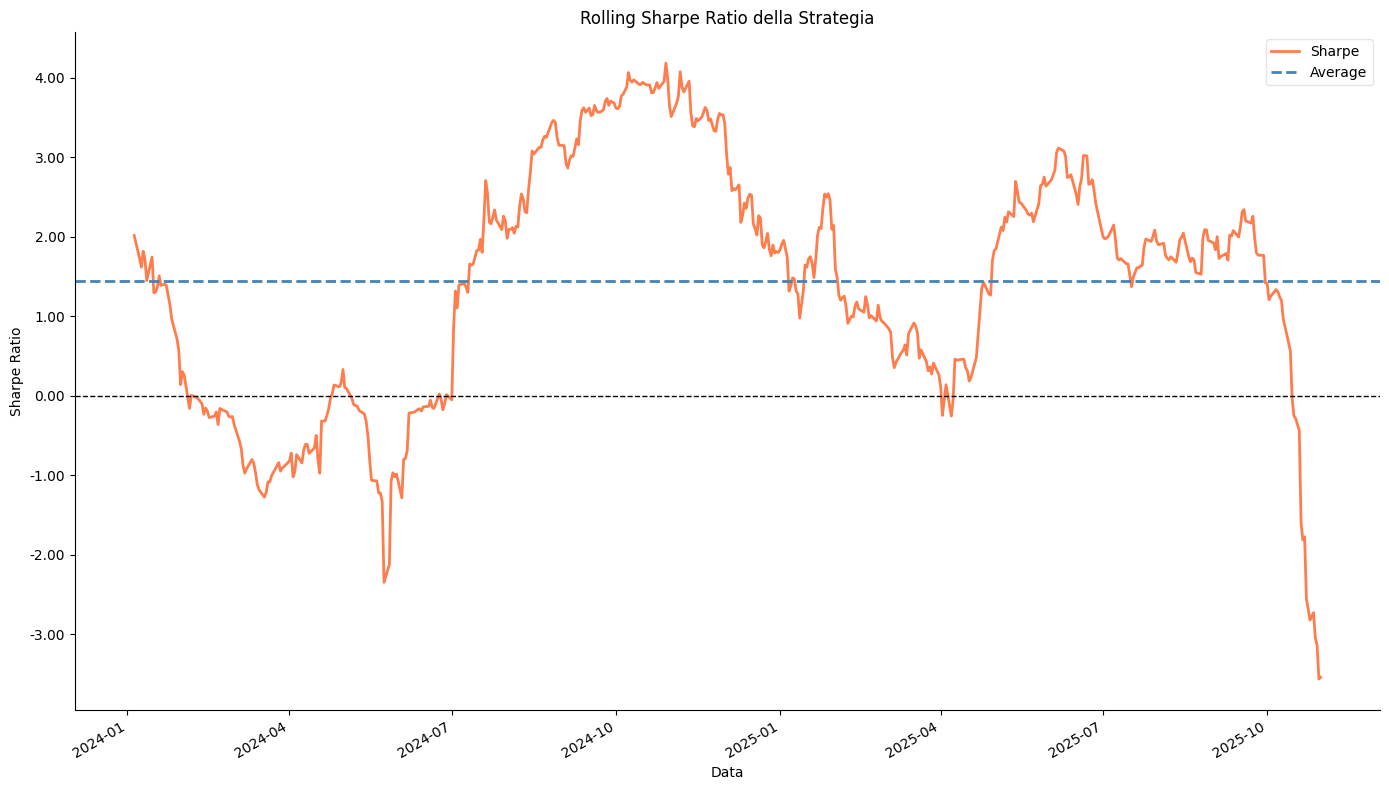

In [26]:
# Usa la Series dei ritorni, non il DataFrame
plot_rolling_sharpe(returns['returns'])
plt.gcf().set_size_inches(14, 8)
plt.title("Rolling Sharpe Ratio della Strategia")
plt.xlabel("Data")
plt.ylabel("Sharpe Ratio")
try:
    sns.despine()
except Exception as e:
    print("sns.despine() non ha avuto effetto:", e)
plt.tight_layout();

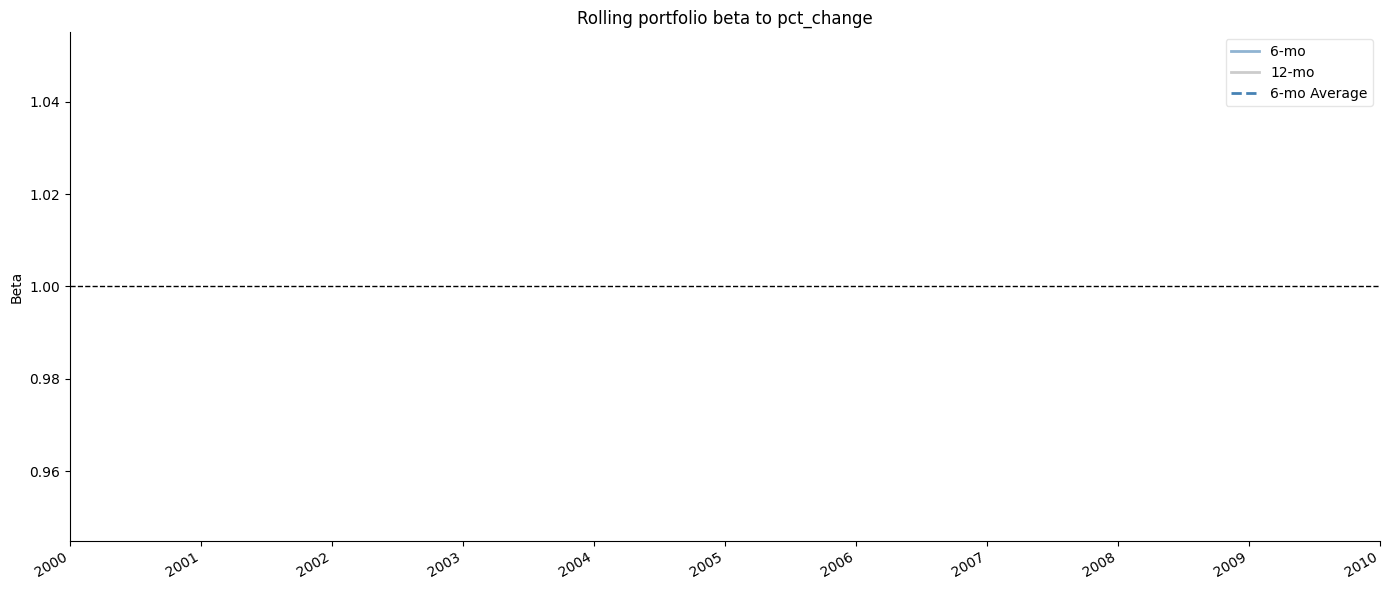

In [27]:
plot_rolling_beta(returns['returns'], factor_returns=benchmark_rets['pct_change'])
plt.gcf().set_size_inches(14, 6)
try:
    sns.despine()
except Exception as e:
    print("sns.despine() non ha avuto effetto:", e)
plt.tight_layout();

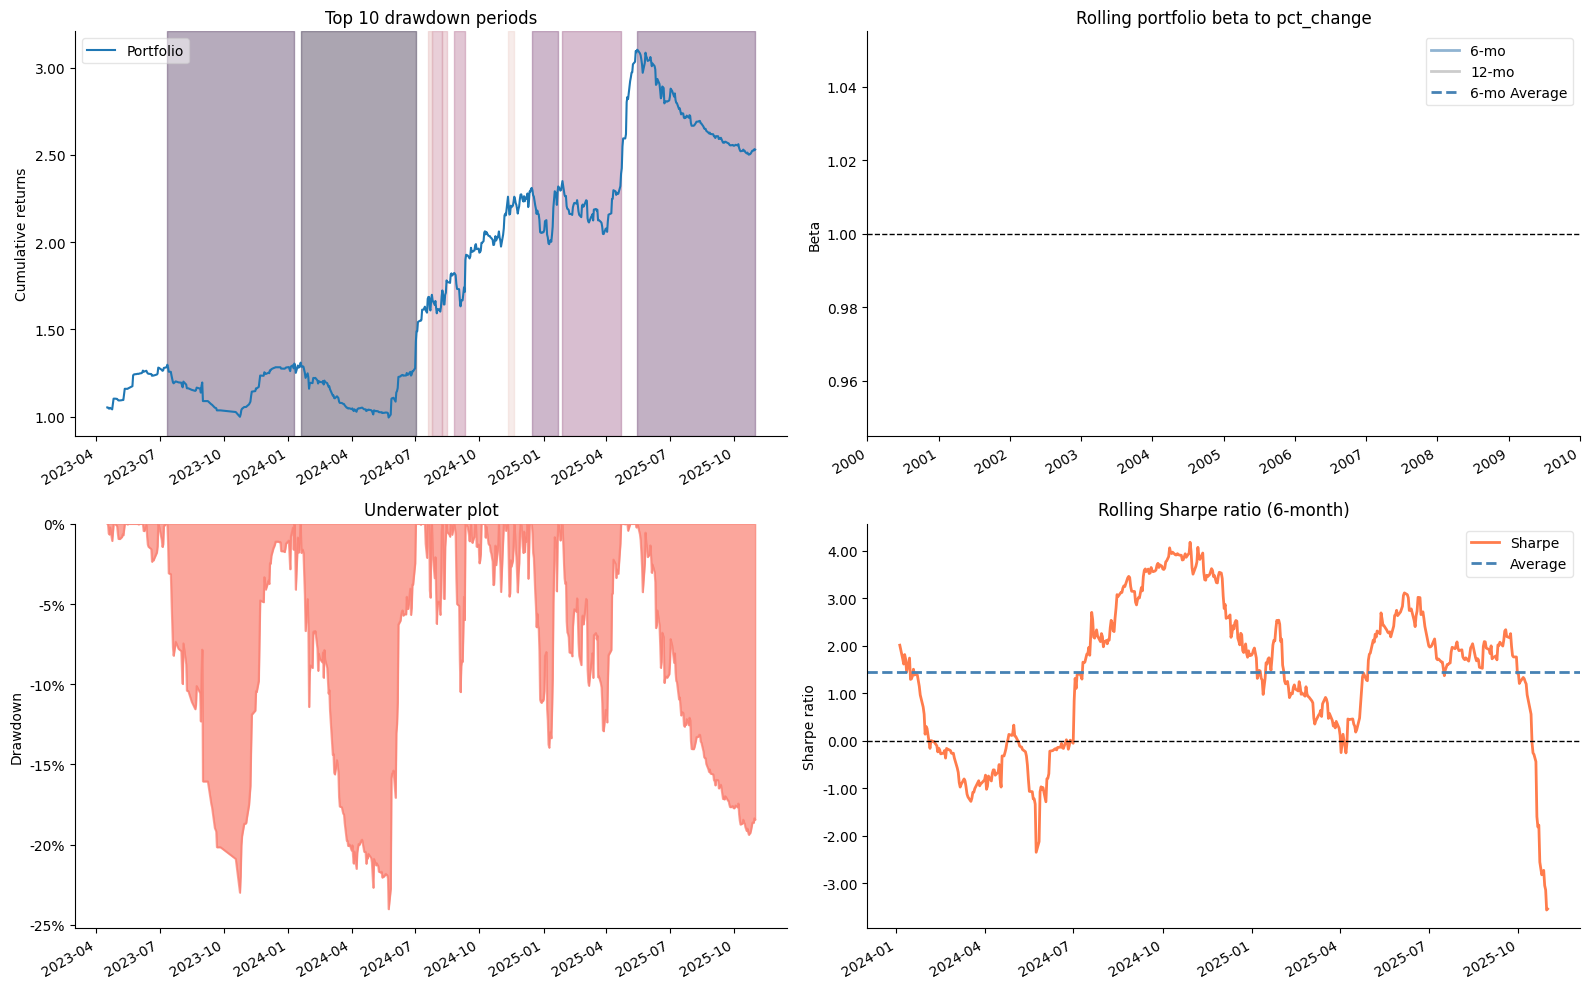

In [28]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))
axes = ax.flatten()

plot_drawdown_periods(returns=returns['returns'], ax=axes[0])
plot_rolling_beta(returns=returns['returns'], factor_returns=benchmark_rets['pct_change'], ax=axes[1])
plot_drawdown_underwater(returns=returns['returns'], ax=axes[2])
plot_rolling_sharpe(returns['returns'])
try:
    sns.despine()
except Exception as e:
    print("sns.despine() non ha avuto effetto:", e)
plt.tight_layout();